# Regrid between curvilinear grids

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe

## Prepare data

### Input data

Here we regrid the built-in "rasm" demo data. This data is used by another [xarray tutorial](http://xarray.pydata.org/en/stable/examples/multidimensional-coords.html#examples-multidim).

In [2]:
ds = xr.tutorial.load_dataset('rasm')
ds

<xarray.Dataset>
Dimensions:  (time: 36, x: 275, y: 205)
Coordinates:
  * time     (time) datetime64[ns] 1980-09-16T12:00:00 1980-10-17 ...
    xc       (y, x) float64 189.2 189.4 189.6 189.7 189.9 190.1 190.2 190.4 ...
    yc       (y, x) float64 16.53 16.78 17.02 17.27 17.51 17.76 18.0 18.25 ...
Dimensions without coordinates: x, y
Data variables:
    Tair     (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       "4.6.0"
    history:                   Tue Dec 2

It is the surface air temperature data, with `nan` over the ocean.

In [3]:
dr = ds['Tair']
dr

<xarray.DataArray 'Tair' (time: 36, y: 205, x: 275)>
array([[[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        ..., 
        [       nan,        nan, ...,  26.802619,  27.086035],
        [       nan,        nan, ...,  26.564739,  26.730649]],

       [[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        ..., 
        [       nan,        nan, ...,  24.29624 ,  24.614224],
        [       nan,        nan, ...,  24.299677,  24.454399]],

       ..., 
       [[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
        ..., 
        [       nan,        nan, ...,  27.311049,  27.673872],
        [       nan,        nan, ...,  27.008894,  27.23018 ]],

       [[       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan],
    

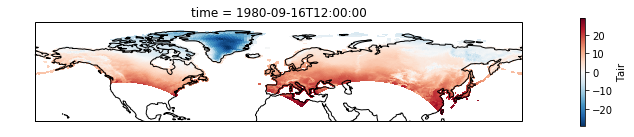

In [4]:
plt.figure(figsize=(12,2));
ax = plt.axes(projection=ccrs.PlateCarree());
dr[0].plot.pcolormesh(ax=ax, x='xc', y='yc');
ax.coastlines();

### Input grid

`xc` and `yc` are longitude and latitude values. They are both 2D arrays, describing a curvilinear grid over high-latitudes. Note that it is totally fine for a grid to span over the south or north pole. ESMF performs regridding in the Cartesian space (x, y, z) so there will be no polar singularities.

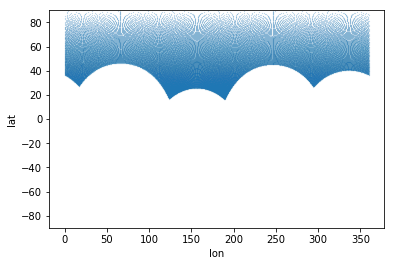

In [5]:
plt.scatter(ds['xc'], ds['yc'], s=0.01)  # plot grid locations
plt.ylim([-90, 90])
plt.xlabel('lon')
plt.ylabel('lat')

We need to rename the coordinate names to `lon` and `lat` because xESMF has no way to guess variable meaning.

In [6]:
ds.rename({'xc': 'lon', 'yc': 'lat'}, inplace=True)
ds

<xarray.Dataset>
Dimensions:  (time: 36, x: 275, y: 205)
Coordinates:
  * time     (time) datetime64[ns] 1980-09-16T12:00:00 1980-10-17 ...
    lon      (y, x) float64 189.2 189.4 189.6 189.7 189.9 190.1 190.2 190.4 ...
    lat      (y, x) float64 16.53 16.78 17.02 17.27 17.51 17.76 18.0 18.25 ...
Dimensions without coordinates: x, y
Data variables:
    Tair     (time, y, x) float64 nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       "4.6.0"
    history:                   Tue Dec 2

### Output grid

Say we want to regrid it to a global $4^\circ \times 5^\circ$ grid. xESMF provides a shortcut to make this output grid.

In [7]:
ds_out = xe.util.grid_global(5, 4)
ds_out  # contains lat/lon values of cell centers and boundaries.

<xarray.Dataset>
Dimensions:  (x: 72, x_b: 73, y: 45, y_b: 46)
Coordinates:
    lon      (y, x) float64 -177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 ...
    lat      (y, x) float64 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 ...
    lon_b    (y_b, x_b) int64 -180 -175 -170 -165 -160 -155 -150 -145 -140 ...
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

The output coordinates are all 2D arrays. They happen to be a rectilinear grid in this case (`lat` is constant over `x` axis, and `lon` is constant over `y` axis), but you can use 2D arrays to specify any curvilinear grids.

## Perform regridding

Regridding is straightforward, just like the previous example.

In [8]:
regridder = xe.Regridder(ds, ds_out, 'bilinear')
dr_out = regridder(dr)

Overwrite existing file: bilinear_205x275_45x72.nc 
 You can set reuse_weights=True to save computing time.


## Check results

Extra dimensions and coordinate values are all correct, like in the previous example.

In [9]:
dr_out

<xarray.DataArray 'Tair' (time: 36, y: 45, x: 72)>
array([[[  0.,   0., ...,   0.,   0.],
        [  0.,   0., ...,   0.,   0.],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[  0.,   0., ...,   0.,   0.],
        [  0.,   0., ...,   0.,   0.],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ..., 
       [[  0.,   0., ...,   0.,   0.],
        [  0.,   0., ...,   0.,   0.],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[  0.,   0., ...,   0.,   0.],
        [  0.,   0., ...,   0.,   0.],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]])
Coordinates:
    lon      (y, x) float64 -177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5 ...
    lat      (y, x) float64 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 -88.0 ...
  * time     (time) datetime64[ns] 1980-09-16T12:00:00 1980-10-17 ...
Dime

The regridding result is consistent with the original data, but now on a rectilinear grid with a coarser resolution. `nan` is mapped to `nan`.

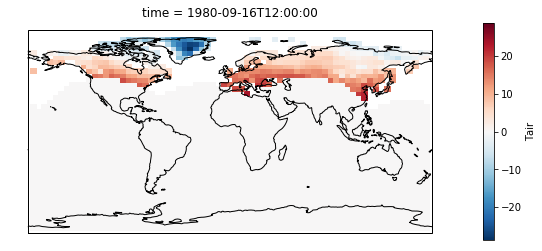

In [10]:
plt.figure(figsize=(12,4));
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out[0].plot.pcolormesh(ax=ax, x='lon', y='lat');
ax.coastlines();

In [11]:
regridder.clean_weight_file()  # clean-up

Remove file bilinear_205x275_45x72.nc
